In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Initial Data Import and Pre Processing

Kaggle Import

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!kaggle datasets download -d rdxesss/covid19-segmentation
!unzip \*.zip && rm *.zip

ID's 

In [ ]:
!pip install q tensorflow==2.1.0
!pip install q keras==2.3.1
!pip install segmentation_models==1.0.1
!pip install h5py==2.10.0
import segmentation_models as sm

# keras==2.3.1
# tensorflow==2.1.0
# segmentation-models==1.0.1
# h5py==2.10.0

# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
# !pip install -U albumentations==0.3.0 --user
!pip install -U albumentations==0.2.3 --user 

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

     |████████████████████████████████| 421.8 MB 5.2 kB/s 
     |████████████████████████████████| 448 kB 40.9 MB/s 
     |████████████████████████████████| 3.8 MB 34.0 MB/s 
     |████████████████████████████████| 50 kB 5.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=e77df5de8ee92ee6bffa18cf2fa264ea834ce91bd5cf729b35781609fd3de82c
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succe

Using TensorFlow backend.


Segmentation Models: using `keras` framework.
     |████████████████████████████████| 64 kB 2.0 MB/s 
     |████████████████████████████████| 47.6 MB 24 kB/s 
     |████████████████████████████████| 631 kB 33.4 MB/s 
  Created wheel for albumentations: filename=albumentations-0.2.3-py3-none-any.whl size=40619 sha256=29cfb6fcb2e3605f339e19e0003bc25492cc38ad23bcdc94f4800b8aa0d16482
  Stored in directory: /root/.cache/pip/wheels/54/7b/67/50aa66430489a1bad29ac8ebe0e31c58eafe5110a38e49b509
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654020 sha256=0e618c96a170b4137bf4fae8461a0b5b45e97569c5b3c6b89686d96867c9c2fd
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
Successfully built albumentations imgaug


Directory Load

In [ ]:
import os
patchsize = 384

# Training data
x_train_dir = '/content/datacovd19/train/images'
y_train_dir = '/content/datacovd19/train/masks'

# Validation data
x_valid_dir = '/content/datacovd19/val/images'
y_valid_dir = '/content/datacovd19/val/masks'


x_test_dir = '/content/datacovd19/test/images'
y_test_dir = '/content/datacovd19/test/masks'

print("Training and validation samples: ", len(os.listdir(x_train_dir)), len(os.listdir(x_valid_dir)), len(os.listdir(x_test_dir)))

Training and validation samples:  2840 680 500


In [ ]:
#Dataloader and utility functions
    
# Helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    
    norm=plt.Normalize(0,4) # 5 classes including BG
    map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", "black","red","blue"])

    
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap=map_name, norm=norm)
    plt.show()
    
    
# Helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

Data Loading and Pre Processing

In [ ]:
import albumentations as A

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.Resize(patchsize,patchsize, interpolation=1, always_apply=False, p=1),
        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.RandomCrop(height=patchsize, width=patchsize, always_apply=True), # patchsize instead of 320

        A.IAAAdditiveGaussianNoise(p=0.2),
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 96"""
    test_transform = [
        A.Resize(patchsize,patchsize, interpolation=1, always_apply=False, p=1),
        A.PadIfNeeded(patchsize, patchsize)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Resize(patchsize,patchsize, interpolation=1, always_apply=False, p=1),
    ]
    return A.Compose(_transform)

In [ ]:
# Classes for data loading and preprocessing
class Dataset:
    """Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['RightLung', 'LeftLung', 'Disease', 'unlabelled']
   
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        
        # Sorted
        self.images_fps = sorted([os.path.join(images_dir, image_id) for image_id in self.ids])
        self.masks_fps = sorted([os.path.join(masks_dir, image_id) for image_id in self.ids])

        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls) for cls in classes] # cls used instead of cls.lower()

        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # Read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = skimage.io.imread(self.images_fps[i])
        
        
        mask = cv2.imread(self.masks_fps[i], 0)
        #mask = skimage.io.imread(self.masks_fps[i])
        
        
        # Extract certain classes from mask
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # Add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # Apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # Apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [ ]:
import random
#Test the dataset class
# Load a random image from the images folder
image_fns = sorted(next(os.walk(x_train_dir))[2])
gt_fns = sorted(next(os.walk(y_train_dir))[2])
print(image_fns[:3], gt_fns[:3])

# Get random number
idx = random.randrange(len(image_fns))
print("Index: ", idx)

import skimage
from skimage import io
# Read image and mask
image = io.imread(os.path.join(x_train_dir, image_fns[idx]))
gt = io.imread(os.path.join(y_train_dir, gt_fns[idx]))

print(image.shape, gt.shape)

val1 = gt.flatten()
print("Ground truth classes: ", np.unique(val1))

['1.png', '10.png', '100.png'] ['1.png', '10.png', '100.png']
Index:  1697
(256, 256) (256, 256)
Ground truth classes:  [0 1 2 3]


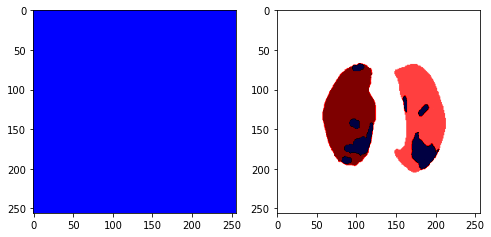

In [ ]:
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()


#####################################################
    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        # newer version of tf/keras want batch to be in tuple rather than list
        return tuple(batch)
#########################################################

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # Transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)


import matplotlib.colors
norm=plt.Normalize(0,4) # 5 classes including BG
map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", "red","black","blue"])

f, axarr = plt.subplots(1,2, figsize=(8,8))

# idx = 94 all classes

axarr[0].imshow(image, cmap=map_name, norm=norm)
axarr[1].imshow(gt, cmap=map_name, norm=norm)

(256, 256, 3) (256, 256, 4)


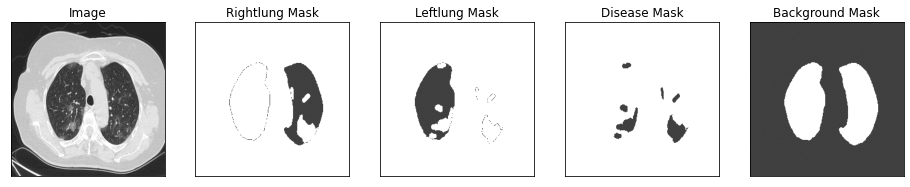

(256, 256, 3) (256, 256, 4)


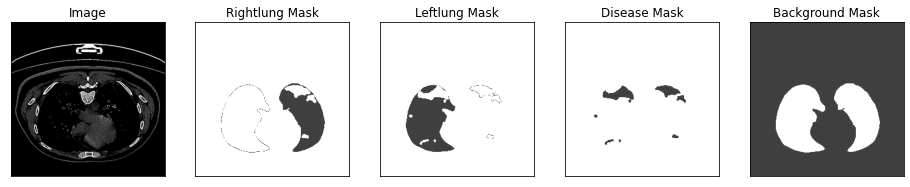

(256, 256, 3) (256, 256, 4)


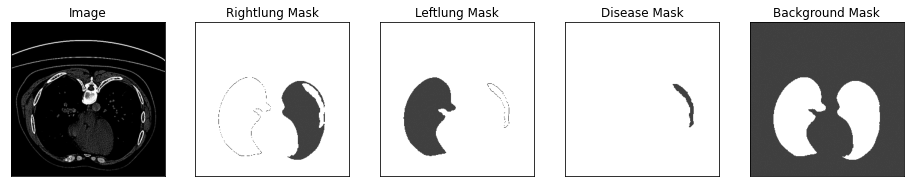

(256, 256, 3) (256, 256, 4)


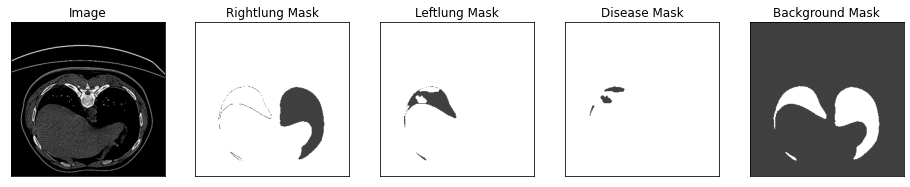

(256, 256, 3) (256, 256, 4)


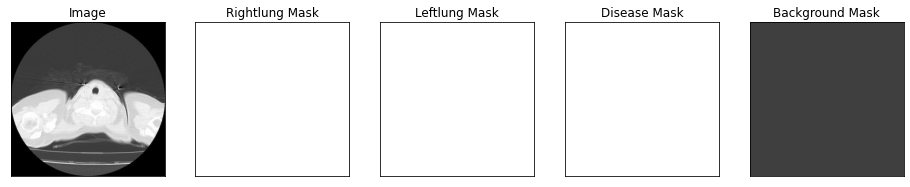

(256, 256, 3) (256, 256, 4)


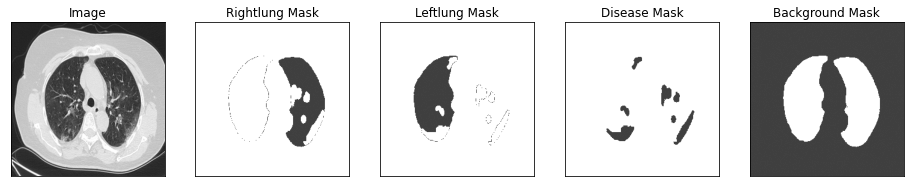

In [ ]:
med= ['RightLung', 'LeftLung', 'Disease']

dataset = Dataset(x_train_dir, y_train_dir, classes=med)
image, mask = dataset[idx] 

print(image.shape, mask.shape)
visualize(
    image=image, 
    RightLung_mask = mask[..., 1].squeeze(),
    LeftLung_mask = mask[..., 2].squeeze(),
    Disease_mask = mask[..., 3].squeeze(),
    background_mask = mask[..., 0].squeeze(),
)

med= ['RightLung', 'LeftLung', 'Disease']

dataset = Dataset(x_train_dir, y_train_dir, classes=med)

for i in range(5):
    
    image, mask = dataset[random.randrange(len(dataset))] # get some sample
    print(image.shape, mask.shape)
    
    visualize(
    image=image, 
    RightLung_mask = mask[..., 1].squeeze(),
    LeftLung_mask = mask[..., 2].squeeze(),
    Disease_mask = mask[..., 3].squeeze(),
    background_mask = mask[..., 0].squeeze(),
    )

Heavy Image Augmentation

(384, 384, 3) (384, 384, 4)


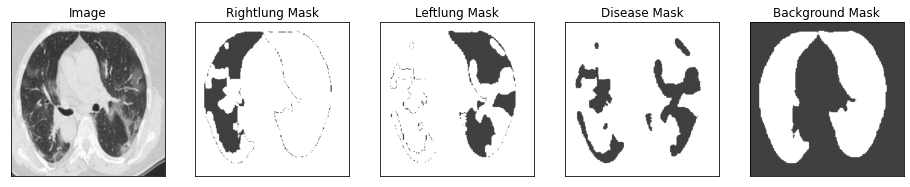

(384, 384, 3) (384, 384, 4)


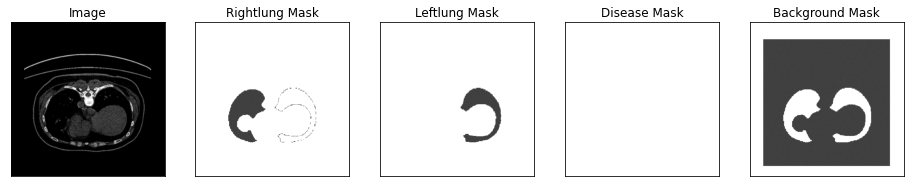

(384, 384, 3) (384, 384, 4)


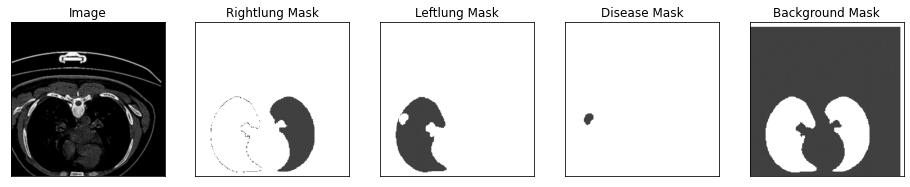

(384, 384, 3) (384, 384, 4)


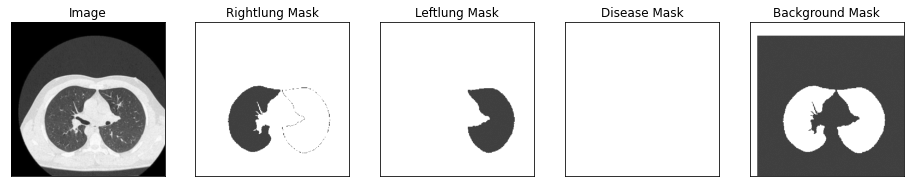

(384, 384, 3) (384, 384, 4)


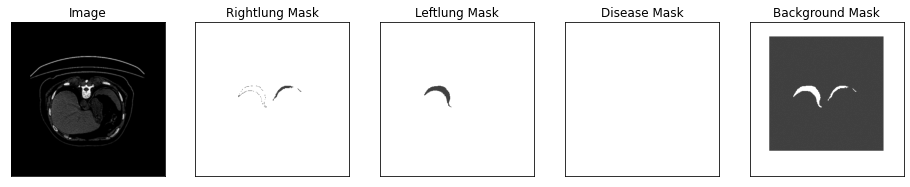

In [ ]:
dataset = Dataset(x_train_dir, y_train_dir, classes=med, augmentation=get_training_augmentation())
for i in range(5):
    
    image, mask = dataset[random.randrange(len(dataset))] # get some sample
    print(image.shape, mask.shape)
    
    visualize(
    image=image, 
    RightLung_mask = mask[..., 1].squeeze(),
    LeftLung_mask = mask[..., 2].squeeze(),
    Disease_mask = mask[..., 3].squeeze(),
    background_mask = mask[..., 0].squeeze(),
    )

# PSPNet + EfficientnetB3

Model Creation

In [ ]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`


BACKBONE = 'efficientnetb3'
BATCH_SIZE = 16
CLASSES = med
LR = 0.0001
EPOCHS = 25

preprocess_input = sm.get_preprocessing(BACKBONE)


# define network parameters
n_classes = 4 # case for binary and multiclass segmentation
activation = 'softmax' 

# #create model
model = sm.PSPNet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet', input_shape = (384, 384, 3))



# model = sm.Unet(BACKBONE,  encoder_weights='imagenet', input_shape = (256, 256, 3))
# I personally would chose (None, None, 3) for the input shape
#

44113920/44107200 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 384, 384, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 192, 192, 40) 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 192, 192, 40) 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 192, 192, 40) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model.compile(optim, total_loss, metrics)

Error check

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 384, 384, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 384, 384, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
 #   keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Z Segmentation/Linknet/Models/efficientnetb3.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau()
  #  keras.callbacks.CSVLogger('/content/drive/MyDrive/Z Segmentation/Linknet/CSV/efficientnetb3.csv', separator=",", append=True)
]

Training

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=25, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/25
177/177 [==============================] - 433s 2s/step - loss: 0.1845 - iou_score: 0.2326 - f1-score: 0.2885 - val_loss: 0.1074 - val_iou_score: 0.4417 - val_f1-score: 0.4672
Epoch 2/25
177/177 [==============================] - 413s 2s/step - loss: 0.1429 - iou_score: 0.3096 - f1-score: 0.3880 - val_loss: 0.0882 - val_iou_score: 0.4938 - val_f1-score: 0.5288
Epoch 3/25
177/177 [==============================] - 414s 2s/step - loss: 0.1314 - iou_score: 0.3438 - f1-score: 0.4262 - val_loss: 0.0854 - val_iou_score: 0.4937 - val_f1-score: 0.5226
Epoch 4/25
177/177 [==============================] - 414s 2s/step - loss: 0.1256 - iou_score: 0.3710 - f1-score: 0.4556 - val_loss: 0.0988 - val_iou_score: 0.4814 - val_f1-score: 0.5065
Epoch 5/25
177/177 [==============================] - 414s 2s/step - loss: 0.1210 - iou_score: 0.3895 - f1-score: 0.4766 - val_loss: 0.0535 - val_iou_score: 0.5356 - val_f1-score: 0.5754
Epoch 6/25
177/177 [==============================] - 414s 2s/ste

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.09683
mean iou_score: 0.42148
mean f1-score: 0.50657


In [ ]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.048533
mean iou_score: 0.5727
mean f1-score: 0.62179


Graphs

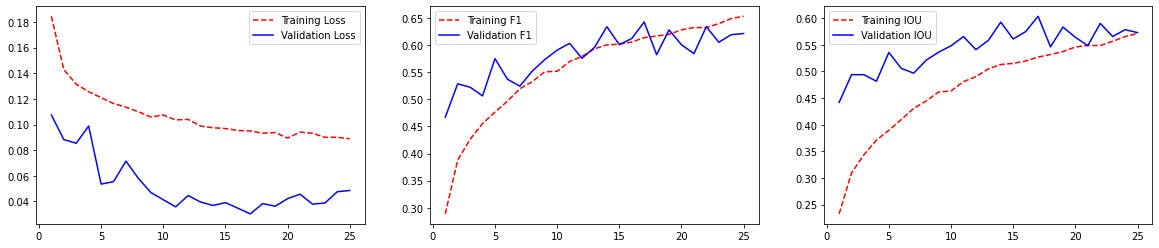

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (20, 4))

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy4 = history.history['f1-score']
validation_accuracy4 = history.history['val_f1-score']

training_accuracy5 = history.history['iou_score']
validation_accuracy5 = history.history['val_iou_score']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy4, 'r--')
axs[1].plot(epoch_count, validation_accuracy4, 'b-')
axs[1].legend(['Training F1', 'Validation F1'])

axs[2].plot(epoch_count, training_accuracy5, 'r--')
axs[2].plot(epoch_count, validation_accuracy5, 'b-')
axs[2].legend(['Training IOU', 'Validation IOU'])

Testing

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=med, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=16, shuffle=True)

In [ ]:
# # load best weights
# model.load_weights('/content/drive/MyDrive/Z Segmentation/Unet/Models/UnetEB00.h5') 

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.050065
mean iou_score: 0.52899
mean f1-score: 0.59977


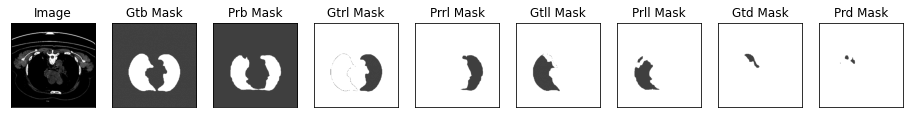

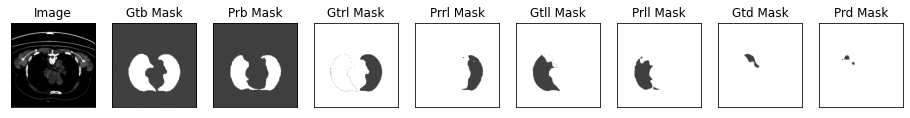

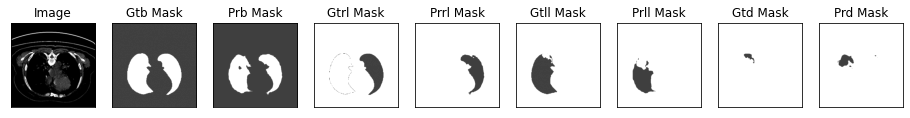

In [ ]:
n = 3
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gtB_mask=gt_mask[..., 0].squeeze(),
        prB_mask=pr_mask[..., 0].squeeze(),
        gtRL_mask=gt_mask[..., 1].squeeze(),
        prRL_mask=pr_mask[..., 1].squeeze(),
        gtLL_mask=gt_mask[..., 2].squeeze(),
        prLL_mask=pr_mask[..., 2].squeeze(),
        gtD_mask=gt_mask[..., 3].squeeze(),
        prD_mask=pr_mask[..., 3].squeeze(),
    )

ROC CURVE

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(K.flatten(test_data_y[..., i]), K.flatten(y_pred[..., i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

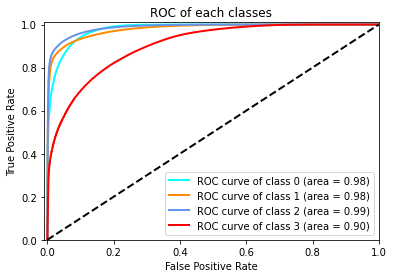

In [ ]:
lw = 2
colors = (['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of each classes')
plt.legend(loc="lower right")
plt.show()

# PSPNet + VGG19

Model Creation

In [ ]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`


BACKBONE = 'vgg19'
BATCH_SIZE = 34
CLASSES = med
LR = 0.0001
EPOCHS = 25

preprocess_input = sm.get_preprocessing(BACKBONE)


# define network parameters
n_classes = 4 # case for binary and multiclass segmentation
activation = 'softmax' 

# #create model
model = sm.PSPNet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet', input_shape = (384, 384, 3))



# model = sm.Unet(BACKBONE,  encoder_weights='imagenet', input_shape = (256, 256, 3))
# I personally would chose (None, None, 3) for the input shape
#

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 384, 384, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 384, 384, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 384, 384, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 192, 192, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model.compile(optim, total_loss, metrics)

Error check

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 384, 384, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 384, 384, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/pspnet/models/pspnetvgg19.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/pspnet/csv/pspnetvgg19.csv', separator=",", append=True)
]

Training

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=25, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/25
83/83 [==============================] - 428s 5s/step - loss: 0.1806 - iou_score: 0.2635 - f1-score: 0.3397 - val_loss: 0.1153 - val_iou_score: 0.4267 - val_f1-score: 0.4914
Epoch 2/25
83/83 [==============================] - 403s 5s/step - loss: 0.1437 - iou_score: 0.3143 - f1-score: 0.3972 - val_loss: 0.1388 - val_iou_score: 0.4729 - val_f1-score: 0.5063
Epoch 3/25
83/83 [==============================] - 402s 5s/step - loss: 0.1324 - iou_score: 0.3450 - f1-score: 0.4296 - val_loss: 0.1521 - val_iou_score: 0.4805 - val_f1-score: 0.5350
Epoch 4/25
83/83 [==============================] - 402s 5s/step - loss: 0.1203 - iou_score: 0.3960 - f1-score: 0.4913 - val_loss: 0.2147 - val_iou_score: 0.4168 - val_f1-score: 0.4533
Epoch 5/25
83/83 [==============================] - 402s 5s/step - loss: 0.1158 - iou_score: 0.4270 - f1-score: 0.5240 - val_loss: 0.2242 - val_iou_score: 0.4073 - val_f1-score: 0.4423
Epoch 6/25
83/83 [==============================] - 402s 5s/step - loss: 0.

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.069494
mean iou_score: 0.69656
mean f1-score: 0.76175


In [ ]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.018037
mean iou_score: 0.74377
mean f1-score: 0.79014


Graphs

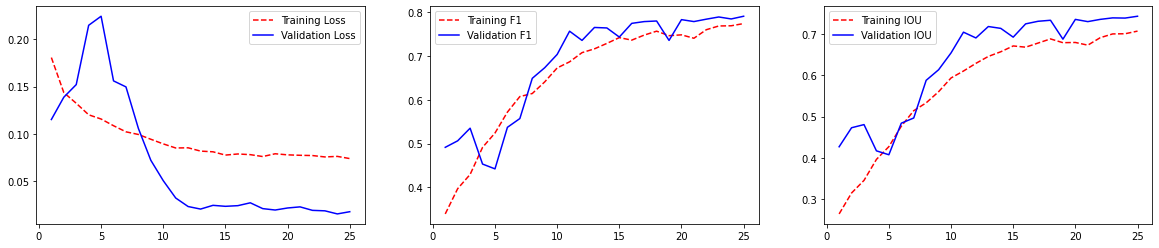

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (20, 4))

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy4 = history.history['f1-score']
validation_accuracy4 = history.history['val_f1-score']

training_accuracy5 = history.history['iou_score']
validation_accuracy5 = history.history['val_iou_score']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy4, 'r--')
axs[1].plot(epoch_count, validation_accuracy4, 'b-')
axs[1].legend(['Training F1', 'Validation F1'])

axs[2].plot(epoch_count, training_accuracy5, 'r--')
axs[2].plot(epoch_count, validation_accuracy5, 'b-')
axs[2].legend(['Training IOU', 'Validation IOU'])

Testing

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=med, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=16, shuffle=True)

In [ ]:
# # load best weights
# model.load_weights('/content/drive/MyDrive/Z Segmentation/Unet/Models/UnetEB00.h5') 

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.018692
mean iou_score: 0.67262
mean f1-score: 0.74026


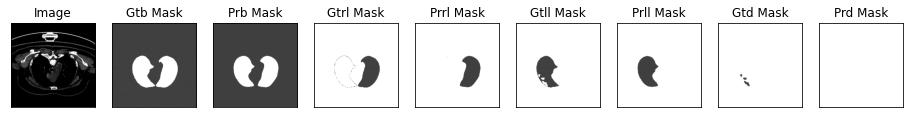

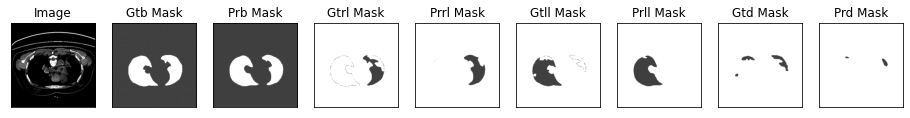

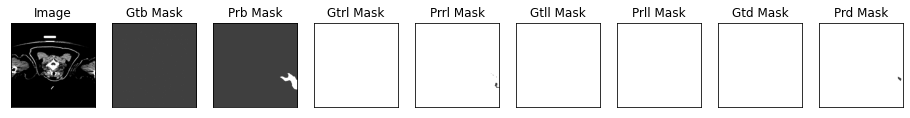

In [ ]:
n = 3
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gtB_mask=gt_mask[..., 0].squeeze(),
        prB_mask=pr_mask[..., 0].squeeze(),
        gtRL_mask=gt_mask[..., 1].squeeze(),
        prRL_mask=pr_mask[..., 1].squeeze(),
        gtLL_mask=gt_mask[..., 2].squeeze(),
        prLL_mask=pr_mask[..., 2].squeeze(),
        gtD_mask=gt_mask[..., 3].squeeze(),
        prD_mask=pr_mask[..., 3].squeeze(),
    )

ROC CURVE

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(K.flatten(test_data_y[..., i]), K.flatten(y_pred[..., i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
lw = 2
colors = (['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of each classes')
plt.legend(loc="lower right")
plt.show()

# PSPNet + inceptionresnetv2

Model Creation

In [ ]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`


BACKBONE = 'inceptionresnetv2'
BATCH_SIZE = 16
CLASSES = med
LR = 0.0001
EPOCHS = 20

preprocess_input = sm.get_preprocessing(BACKBONE)


# define network parameters
n_classes = 4 # case for binary and multiclass segmentation
activation = 'softmax' 

# #create model
model = sm.PSPNet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet', input_shape = (384, 384, 3))



# model = sm.Unet(BACKBONE,  encoder_weights='imagenet', input_shape = (256, 256, 3))
# I personally would chose (None, None, 3) for the input shape
#

219062272/219055592 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 384, 384, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 192, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 192, 192, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 192, 192, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model.compile(optim, total_loss, metrics)

Error check

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 384, 384, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 384, 384, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/pspnet/models/pspnetinceptionresnetv2.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/pspnet/csv/pspnetinceptionresnetv2.csv', separator=",", append=True)
]

Training

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=20, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/20
177/177 [==============================] - 304s 2s/step - loss: 0.1824 - iou_score: 0.2373 - f1-score: 0.2899 - val_loss: 0.1571 - val_iou_score: 0.4465 - val_f1-score: 0.4553
Epoch 2/20
177/177 [==============================] - 301s 2s/step - loss: 0.1377 - iou_score: 0.3312 - f1-score: 0.4098 - val_loss: 0.0991 - val_iou_score: 0.4729 - val_f1-score: 0.4932
Epoch 3/20
177/177 [==============================] - 298s 2s/step - loss: 0.1218 - iou_score: 0.3916 - f1-score: 0.4739 - val_loss: 0.0601 - val_iou_score: 0.5542 - val_f1-score: 0.5946
Epoch 4/20
177/177 [==============================] - 299s 2s/step - loss: 0.1124 - iou_score: 0.4289 - f1-score: 0.5123 - val_loss: 0.0490 - val_iou_score: 0.5384 - val_f1-score: 0.5764
Epoch 5/20
177/177 [==============================] - 298s 2s/step - loss: 0.1043 - iou_score: 0.4662 - f1-score: 0.5474 - val_loss: 0.0855 - val_iou_score: 0.4882 - val_f1-score: 0.5199
Epoch 6/20
177/177 [==============================] - 298s 2s/ste

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.077201
mean iou_score: 0.53524
mean f1-score: 0.61174


In [ ]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.029916
mean iou_score: 0.64616
mean f1-score: 0.68846


Graphs

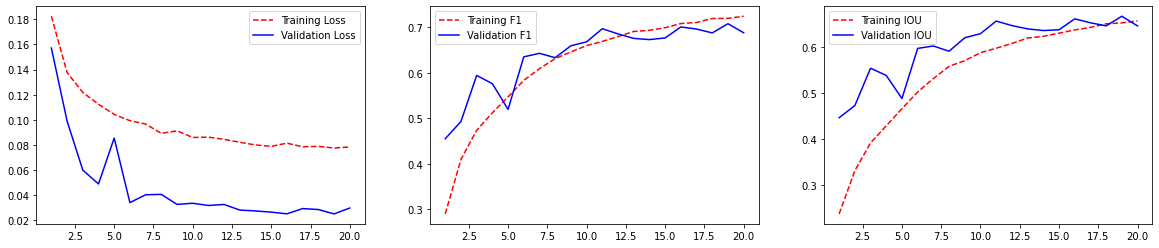

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (20, 4))

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy4 = history.history['f1-score']
validation_accuracy4 = history.history['val_f1-score']

training_accuracy5 = history.history['iou_score']
validation_accuracy5 = history.history['val_iou_score']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy4, 'r--')
axs[1].plot(epoch_count, validation_accuracy4, 'b-')
axs[1].legend(['Training F1', 'Validation F1'])

axs[2].plot(epoch_count, training_accuracy5, 'r--')
axs[2].plot(epoch_count, validation_accuracy5, 'b-')
axs[2].legend(['Training IOU', 'Validation IOU'])

Testing

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=med, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=16, shuffle=True)

In [ ]:
# # load best weights
# model.load_weights('/content/drive/MyDrive/Z Segmentation/Unet/Models/UnetEB00.h5') 

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.037921
mean iou_score: 0.64012
mean f1-score: 0.70967


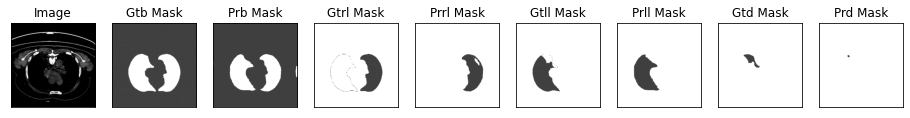

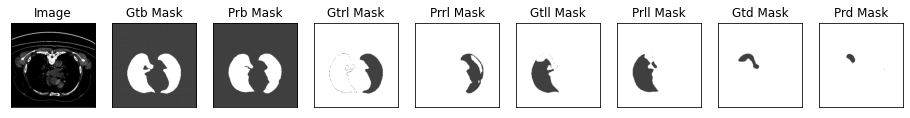

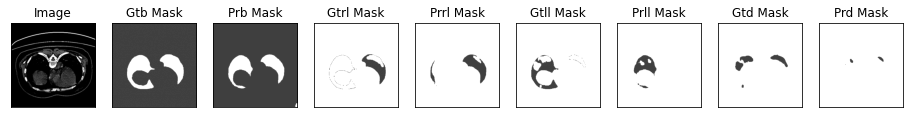

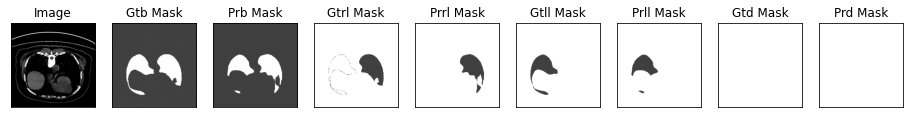

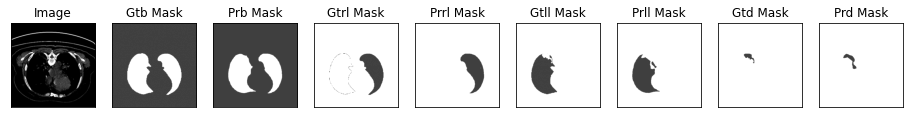

In [ ]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gtB_mask=gt_mask[..., 0].squeeze(),
        prB_mask=pr_mask[..., 0].squeeze(),
        gtRL_mask=gt_mask[..., 1].squeeze(),
        prRL_mask=pr_mask[..., 1].squeeze(),
        gtLL_mask=gt_mask[..., 2].squeeze(),
        prLL_mask=pr_mask[..., 2].squeeze(),
        gtD_mask=gt_mask[..., 3].squeeze(),
        prD_mask=pr_mask[..., 3].squeeze(),
    )

ROC CURVE

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(K.flatten(test_data_y[..., i]), K.flatten(y_pred[..., i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

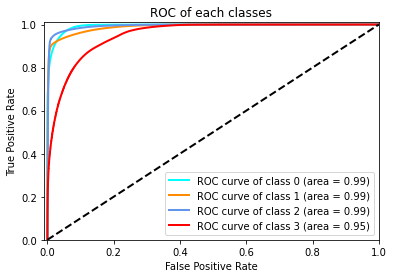

In [ ]:
lw = 2
colors = (['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of each classes')
plt.legend(loc="lower right")
plt.show()

# PSPNet + densenet121

Model Creation

In [ ]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`


BACKBONE = 'densenet121'
BATCH_SIZE = 16
CLASSES = med
LR = 0.0001
EPOCHS = 20

preprocess_input = sm.get_preprocessing(BACKBONE)


# define network parameters
n_classes = 4 # case for binary and multiclass segmentation
activation = 'softmax' 

# #create model
model = sm.PSPNet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet', input_shape = (384, 384, 3))



# model = sm.Unet(BACKBONE,  encoder_weights='imagenet', input_shape = (256, 256, 3))
# I personally would chose (None, None, 3) for the input shape
#

In [ ]:
model.summary()

Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model.compile(optim, total_loss, metrics)

Error check

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 384, 384, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 384, 384, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/pspnet/models/pspnetdensenet121.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/pspnet/csv/pspnetdensenet121.csv', separator=",", append=True)
]

Training

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=20, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/20
177/177 [==============================] - 385s 2s/step - loss: 0.1825 - iou_score: 0.2524 - f1-score: 0.3120 - val_loss: 0.1320 - val_iou_score: 0.4529 - val_f1-score: 0.4615
Epoch 2/20
177/177 [==============================] - 365s 2s/step - loss: 0.1295 - iou_score: 0.3637 - f1-score: 0.4457 - val_loss: 0.0943 - val_iou_score: 0.5218 - val_f1-score: 0.5623
Epoch 3/20
177/177 [==============================] - 365s 2s/step - loss: 0.1148 - iou_score: 0.4180 - f1-score: 0.4997 - val_loss: 0.0657 - val_iou_score: 0.5551 - val_f1-score: 0.5969
Epoch 4/20
177/177 [==============================] - 365s 2s/step - loss: 0.1055 - iou_score: 0.4726 - f1-score: 0.5532 - val_loss: 0.0818 - val_iou_score: 0.5557 - val_f1-score: 0.5984
Epoch 5/20
177/177 [==============================] - 365s 2s/step - loss: 0.0993 - iou_score: 0.5117 - f1-score: 0.5915 - val_loss: 0.0716 - val_iou_score: 0.5648 - val_f1-score: 0.6094
Epoch 6/20
177/177 [==============================] - 365s 2s/ste

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.10836
mean iou_score: 0.54485
mean f1-score: 0.61814


In [ ]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.033013
mean iou_score: 0.66736
mean f1-score: 0.71084


Graphs

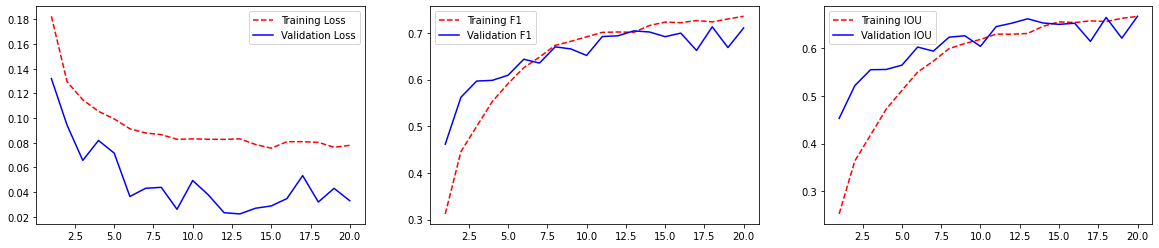

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (20, 4))

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy4 = history.history['f1-score']
validation_accuracy4 = history.history['val_f1-score']

training_accuracy5 = history.history['iou_score']
validation_accuracy5 = history.history['val_iou_score']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy4, 'r--')
axs[1].plot(epoch_count, validation_accuracy4, 'b-')
axs[1].legend(['Training F1', 'Validation F1'])

axs[2].plot(epoch_count, training_accuracy5, 'r--')
axs[2].plot(epoch_count, validation_accuracy5, 'b-')
axs[2].legend(['Training IOU', 'Validation IOU'])

Testing

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=med, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=16, shuffle=True)

In [ ]:
# # load best weights
# model.load_weights('/content/drive/MyDrive/pspnet/models/pspnetdensenet121.h5') 

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.023144
mean iou_score: 0.66042
mean f1-score: 0.72023


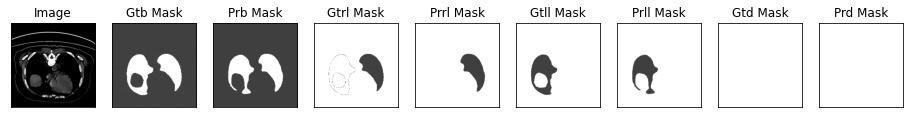

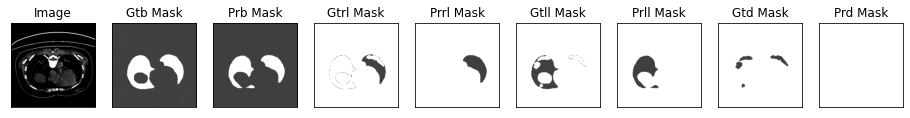

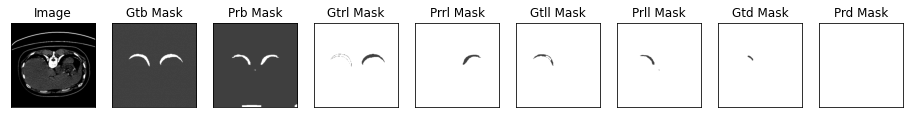

In [ ]:
n = 3
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gtB_mask=gt_mask[..., 0].squeeze(),
        prB_mask=pr_mask[..., 0].squeeze(),
        gtRL_mask=gt_mask[..., 1].squeeze(),
        prRL_mask=pr_mask[..., 1].squeeze(),
        gtLL_mask=gt_mask[..., 2].squeeze(),
        prLL_mask=pr_mask[..., 2].squeeze(),
        gtD_mask=gt_mask[..., 3].squeeze(),
        prD_mask=pr_mask[..., 3].squeeze(),
    )

ROC CURVE

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(K.flatten(test_data_y[..., i]), K.flatten(y_pred[..., i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

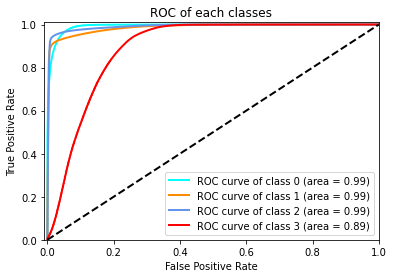

In [ ]:
lw = 2
colors = (['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of each classes')
plt.legend(loc="lower right")
plt.show()

# PSPNet + mobilenetv2

Model Creation

In [ ]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`


BACKBONE = 'mobilenetv2'
BATCH_SIZE = 34
CLASSES = med
LR = 0.0001
EPOCHS = 20

preprocess_input = sm.get_preprocessing(BACKBONE)


# define network parameters
n_classes = 4 # case for binary and multiclass segmentation
activation = 'softmax' 

# #create model
model = sm.PSPNet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet', input_shape = (384, 384, 3))



# model = sm.Unet(BACKBONE,  encoder_weights='imagenet', input_shape = (256, 256, 3))
# I personally would chose (None, None, 3) for the input shape
#

/usr/local/lib/python3.7/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model.compile(optim, total_loss, metrics)

Error check

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 384, 384, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 384, 384, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/pspnet/models/pspnetmobilenetv2.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/pspnet/csv/pspnetmobilenetv2.csv', separator=",", append=True)
]

Training

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=20, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/20
83/83 [==============================] - 234s 3s/step - loss: 0.2063 - iou_score: 0.2049 - f1-score: 0.2488 - val_loss: 0.1600 - val_iou_score: 0.4127 - val_f1-score: 0.4299
Epoch 2/20
83/83 [==============================] - 219s 3s/step - loss: 0.1568 - iou_score: 0.2684 - f1-score: 0.3388 - val_loss: 0.1526 - val_iou_score: 0.4114 - val_f1-score: 0.4432
Epoch 3/20
83/83 [==============================] - 219s 3s/step - loss: 0.1456 - iou_score: 0.3136 - f1-score: 0.3972 - val_loss: 0.1176 - val_iou_score: 0.4316 - val_f1-score: 0.4608
Epoch 4/20
83/83 [==============================] - 219s 3s/step - loss: 0.1380 - iou_score: 0.3326 - f1-score: 0.4188 - val_loss: 0.1465 - val_iou_score: 0.4295 - val_f1-score: 0.4610
Epoch 5/20
83/83 [==============================] - 220s 3s/step - loss: 0.1309 - iou_score: 0.3531 - f1-score: 0.4415 - val_loss: 0.1025 - val_iou_score: 0.4410 - val_f1-score: 0.4733
Epoch 6/20
83/83 [==============================] - 220s 3s/step - loss: 0.

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.090636
mean iou_score: 0.27067
mean f1-score: 0.34131


In [ ]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.077744
mean iou_score: 0.48372
mean f1-score: 0.51853


Graphs

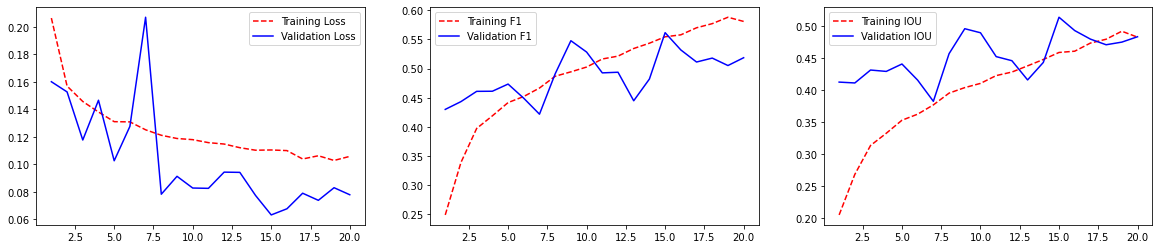

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (20, 4))

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy4 = history.history['f1-score']
validation_accuracy4 = history.history['val_f1-score']

training_accuracy5 = history.history['iou_score']
validation_accuracy5 = history.history['val_iou_score']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy4, 'r--')
axs[1].plot(epoch_count, validation_accuracy4, 'b-')
axs[1].legend(['Training F1', 'Validation F1'])

axs[2].plot(epoch_count, training_accuracy5, 'r--')
axs[2].plot(epoch_count, validation_accuracy5, 'b-')
axs[2].legend(['Training IOU', 'Validation IOU'])

Testing

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=med, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=16, shuffle=True)

In [ ]:
# # load best weights
model.load_weights('/content/drive/MyDrive/pspnet/models/pspnetmobilenetv2.h5') 

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.067639
mean iou_score: 0.47817
mean f1-score: 0.538


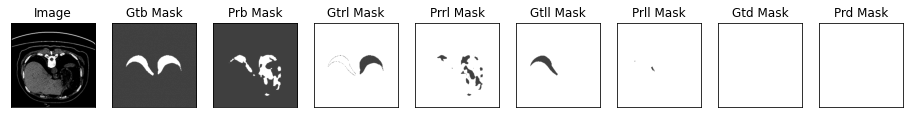

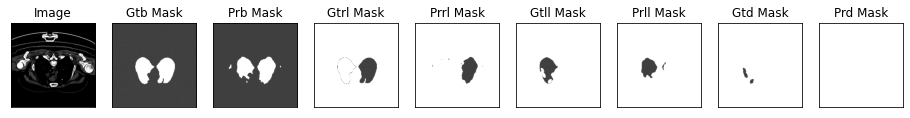

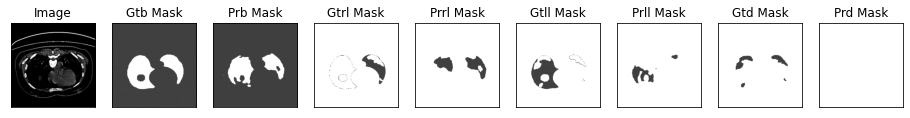

In [ ]:
n = 3
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gtB_mask=gt_mask[..., 0].squeeze(),
        prB_mask=pr_mask[..., 0].squeeze(),
        gtRL_mask=gt_mask[..., 1].squeeze(),
        prRL_mask=pr_mask[..., 1].squeeze(),
        gtLL_mask=gt_mask[..., 2].squeeze(),
        prLL_mask=pr_mask[..., 2].squeeze(),
        gtD_mask=gt_mask[..., 3].squeeze(),
        prD_mask=pr_mask[..., 3].squeeze(),
    )

ROC CURVE

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(K.flatten(test_data_y[..., i]), K.flatten(y_pred[..., i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

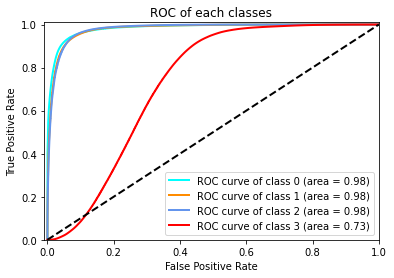

In [ ]:
lw = 2
colors = (['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of each classes')
plt.legend(loc="lower right")
plt.show()

# PSPNet + seresnet101

Model Creation

In [ ]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`


BACKBONE = 'seresnet101'
BATCH_SIZE = 16
CLASSES = med
LR = 0.0001
EPOCHS = 20

preprocess_input = sm.get_preprocessing(BACKBONE)


# define network parameters
n_classes = 4 # case for binary and multiclass segmentation
activation = 'softmax' 

# #create model
model = sm.PSPNet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet', input_shape = (384, 384, 3))



# model = sm.Unet(BACKBONE,  encoder_weights='imagenet', input_shape = (256, 256, 3))
# I personally would chose (None, None, 3) for the input shape
#

190668800/190663368 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 384, 384, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 390, 390, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 192, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 192, 192, 64) 256         conv2d_1[0][0]                   
____________________________________________________________________________________________

Loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#ComboLoss
#The main idea of using Combo loss is very simple:
#
#Tversky Loss and weighted bce -> reduce the false positive Focal Loss -> Learn hard samples in training set
#
#SOURCE : https://www.kaggle.com/xiejialun/seunet-with-comboloss-swish
#

def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef

def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0):
    
    # if flatten:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss

def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(labels = y_true, logits = y_pred, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy

def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)

total_loss= Combo_Loss

Compiler

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

import keras.backend as K
import tensorflow as tf

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model.compile(optim, total_loss, metrics)

Error check

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 384, 384, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 384, 384, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/pspnet/models/pspnetseresnet101.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.CSVLogger('/content/drive/MyDrive/pspnet/csv/pspnetseresnet101.csv', separator=",", append=True)
]

Training

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=20, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/20
177/177 [==============================] - 350s 2s/step - loss: 0.1621 - iou_score: 0.2876 - f1-score: 0.3594 - val_loss: 0.0934 - val_iou_score: 0.4585 - val_f1-score: 0.4847
Epoch 2/20
177/177 [==============================] - 330s 2s/step - loss: 0.1262 - iou_score: 0.3681 - f1-score: 0.4519 - val_loss: 0.0817 - val_iou_score: 0.4772 - val_f1-score: 0.5078
Epoch 3/20
177/177 [==============================] - 330s 2s/step - loss: 0.1145 - iou_score: 0.4227 - f1-score: 0.5122 - val_loss: 0.0431 - val_iou_score: 0.5741 - val_f1-score: 0.6198
Epoch 4/20
177/177 [==============================] - 329s 2s/step - loss: 0.1051 - iou_score: 0.4692 - f1-score: 0.5579 - val_loss: 0.0612 - val_iou_score: 0.5155 - val_f1-score: 0.5601
Epoch 5/20
177/177 [==============================] - 330s 2s/step - loss: 0.0949 - iou_score: 0.5161 - f1-score: 0.6033 - val_loss: 0.0332 - val_iou_score: 0.5849 - val_f1-score: 0.6284
Epoch 6/20
177/177 [==============================] - 330s 2s/ste

In [ ]:
scores = model.evaluate_generator(train_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.11678
mean iou_score: 0.5182
mean f1-score: 0.59157


In [ ]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.031484
mean iou_score: 0.62258
mean f1-score: 0.66697


Graphs

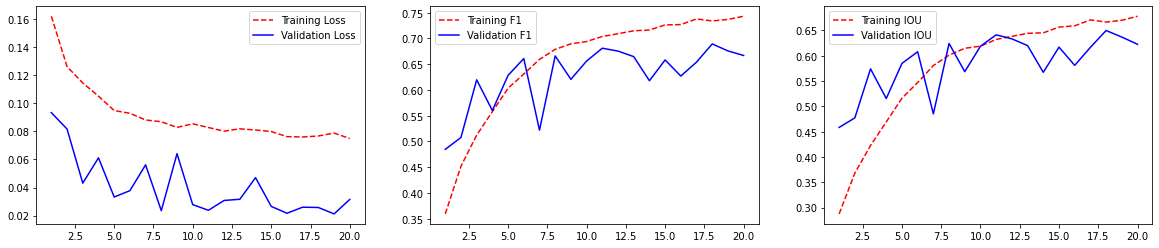

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (20, 4))

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy4 = history.history['f1-score']
validation_accuracy4 = history.history['val_f1-score']

training_accuracy5 = history.history['iou_score']
validation_accuracy5 = history.history['val_iou_score']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy4, 'r--')
axs[1].plot(epoch_count, validation_accuracy4, 'b-')
axs[1].legend(['Training F1', 'Validation F1'])

axs[2].plot(epoch_count, training_accuracy5, 'r--')
axs[2].plot(epoch_count, validation_accuracy5, 'b-')
axs[2].legend(['Training IOU', 'Validation IOU'])

Testing

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=med, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=16, shuffle=True)

In [ ]:
# # load best weights
# model.load_weights('/content/drive/MyDrive/Z Segmentation/Unet/Models/UnetEB00.h5') 

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.040224
mean iou_score: 0.59135
mean f1-score: 0.66851


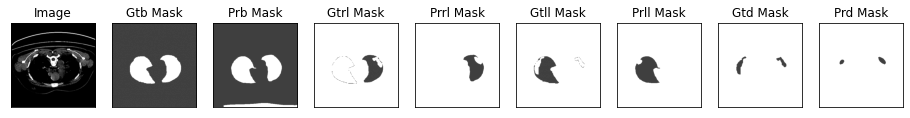

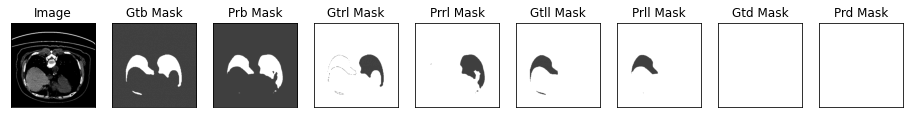

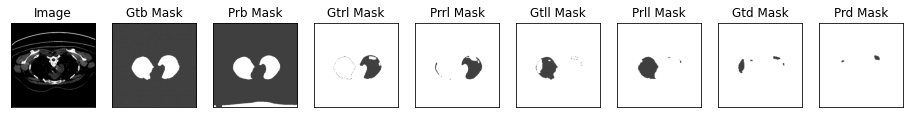

In [ ]:
n = 3
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gtB_mask=gt_mask[..., 0].squeeze(),
        prB_mask=pr_mask[..., 0].squeeze(),
        gtRL_mask=gt_mask[..., 1].squeeze(),
        prRL_mask=pr_mask[..., 1].squeeze(),
        gtLL_mask=gt_mask[..., 2].squeeze(),
        prLL_mask=pr_mask[..., 2].squeeze(),
        gtD_mask=gt_mask[..., 3].squeeze(),
        prD_mask=pr_mask[..., 3].squeeze(),
    )

ROC CURVE

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(K.flatten(test_data_y[..., i]), K.flatten(y_pred[..., i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
lw = 2
colors = (['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of each classes')
plt.legend(loc="lower right")
plt.show()